In [17]:
import pandas as pd
import seaborn as sns
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'Fengyun-2D - Brouwer Mean Motion')

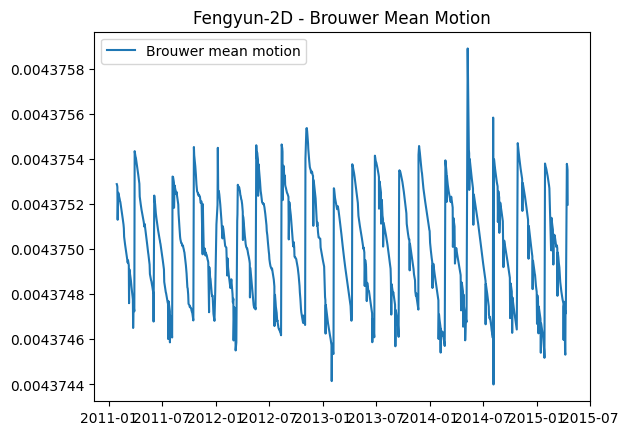

In [18]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Fengyun-2D.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("Fengyun-2D - Brouwer Mean Motion")

In [19]:
# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/manFY2D.txt.fy'

data = []

# Reading the file data into the list
with open(maneuver_file_path, 'r') as file:
    for line in file:
        # Splitting the line by space
        parts = line.strip().split('"')
        #maneuver_type, satellite_id = parts[0].strip().split()[:2]
        start_date = parts[1]
        #end_time = parts[3]
        data.append(start_date)

# Defining the column names
column_names = ['Start_Date']

# Creating a dataframe with the text file data
df = pd.DataFrame(data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])

# Checking the dataframe
print(df.head())

           Start_Date
0 2015-04-10 15:30:00
1 2015-01-27 14:30:00
2 2014-10-24 15:30:00
3 2014-08-04 15:30:00
4 2014-05-09 15:30:00


/var/folders/5m/f9w6_kb12kn6r38z9rjzgfk00000gn/T/ipykernel_1397/2644158969.py:23: FutureWarning: Parsed string "2015-04-10T15:30:00 CST" included an un-recognized timezone "CST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Start_Date'] = pd.to_datetime(df['Start_Date'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

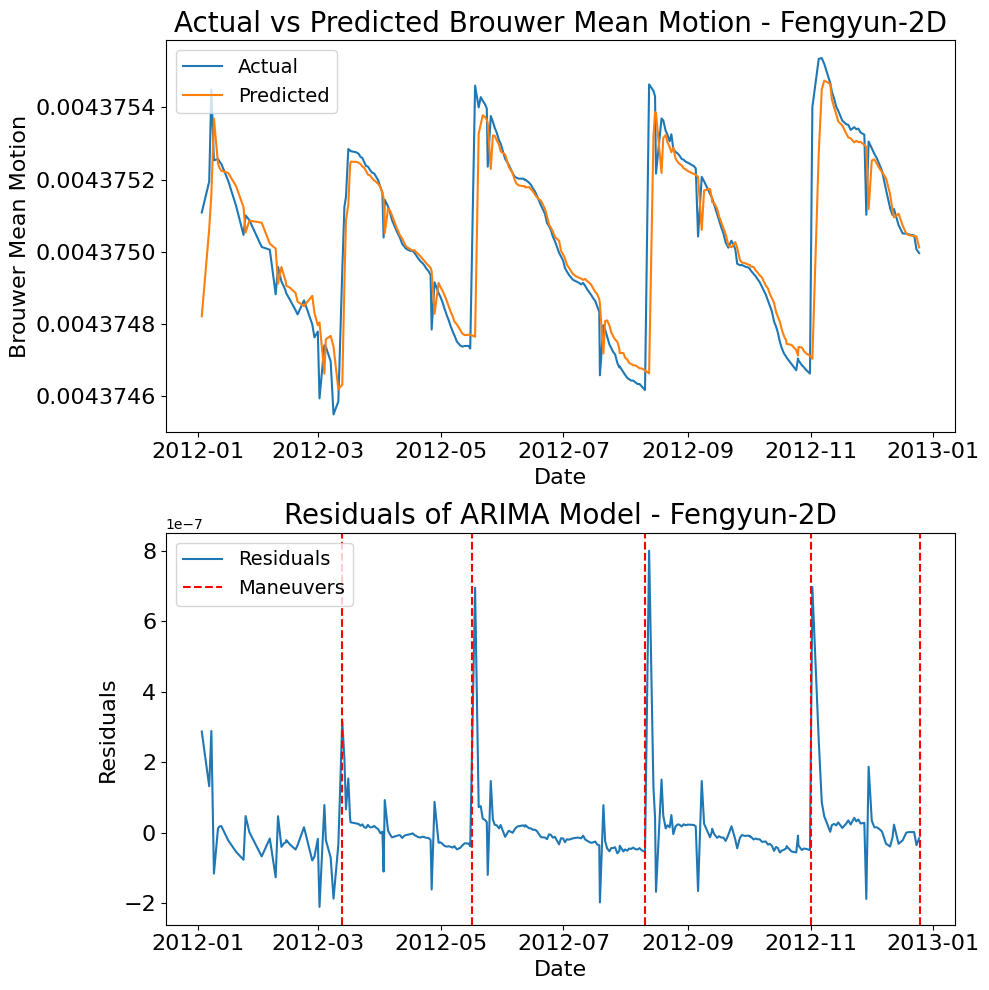

In [20]:
# Fitting an ARIMA model to the entire dataset
arima_model = ARIMA(df_bmm,order = (1,0,1))
arima_model_fit = arima_model.fit()

# Making predictions
predictions = arima_model_fit.predict(start = 0, end = len(df_bmm) - 1, typ = 'levels')

# Calculating residuals
residuals = df_bmm['Brouwer mean motion'] - predictions

# Defining date ranges
start_date = pd.to_datetime("2012-01-01")
end_date = pd.to_datetime("2012-12-31")

# Filtering the actual, predictions and residuals based on the date range
actual_filtered = df_bmm[start_date:end_date]
predictions_filtered = predictions[start_date:end_date]
residuals_filtered = residuals[start_date:end_date]

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = actual_filtered.index, y = actual_filtered["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = predictions_filtered.index, y = predictions_filtered, label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - Fengyun-2D",fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=16)

# Plotting residuals
sns.lineplot(x = residuals_filtered.index, y = residuals_filtered, label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of ARIMA Model - Fengyun-2D",fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [21]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = residuals.abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series

2011-01-27 14:08:12.153119    2.718723e-07
2011-01-28 17:37:05.756160    3.023856e-08
2011-01-29 15:15:38.467295    2.207224e-08
2011-01-30 15:10:21.948671    1.170145e-07
2011-02-01 14:21:40.146048    1.163021e-07
                                  ...     
2015-04-10 01:46:29.584127    2.207811e-08
2015-04-13 13:46:11.083296    6.301984e-07
2015-04-14 20:58:23.309760    1.052007e-07
2015-04-15 21:43:48.910080    3.212605e-08
2015-04-16 09:12:35.675136    1.165451e-07
Length: 1187, dtype: float64

In [22]:
# Sorting the residuals
residuals_series.sort_values
residuals_series

2011-01-27 14:08:12.153119    2.718723e-07
2011-01-28 17:37:05.756160    3.023856e-08
2011-01-29 15:15:38.467295    2.207224e-08
2011-01-30 15:10:21.948671    1.170145e-07
2011-02-01 14:21:40.146048    1.163021e-07
                                  ...     
2015-04-10 01:46:29.584127    2.207811e-08
2015-04-13 13:46:11.083296    6.301984e-07
2015-04-14 20:58:23.309760    1.052007e-07
2015-04-15 21:43:48.910080    3.212605e-08
2015-04-16 09:12:35.675136    1.165451e-07
Length: 1187, dtype: float64

In [23]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0    2015-04-10 15:30:00
1    2015-01-27 14:30:00
2    2014-10-24 15:30:00
3    2014-08-04 15:30:00
4    2014-05-09 15:30:00
5    2014-02-20 15:30:00
6    2013-11-22 15:30:00
7    2013-09-16 15:30:00
8    2013-06-25 15:30:00
9    2013-04-09 15:30:00
10   2013-02-05 15:30:00
11   2012-12-25 11:00:00
12   2012-11-01 09:30:00
13   2012-08-10 15:00:00
14   2012-05-16 10:00:00
15   2012-03-12 15:30:00
16   2011-12-29 16:30:00
17   2011-10-17 09:00:00
18   2011-08-04 15:30:00
19   2011-06-02 15:30:00
20   2011-03-28 16:00:00
21   2011-02-01 15:00:00
Name: Start_Date, dtype: datetime64[ns]

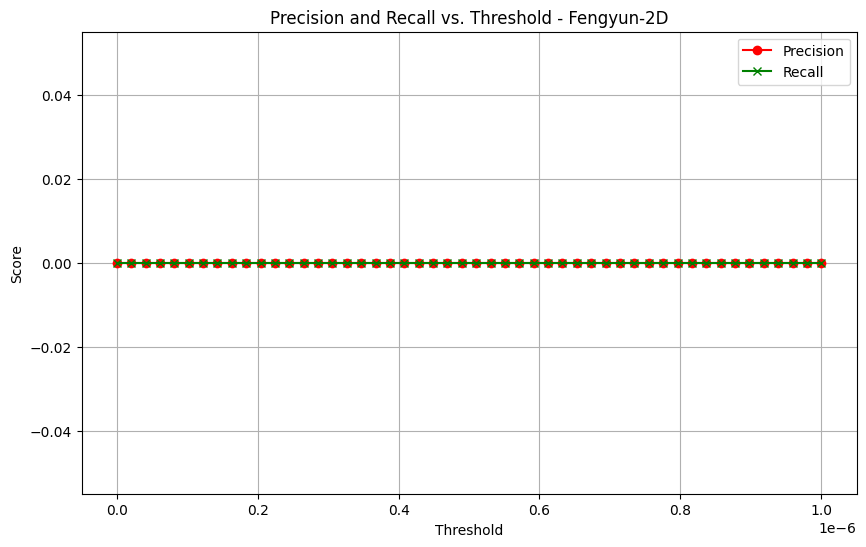

In [31]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(10,6))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - Fengyun-2D')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,0.000001,50)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

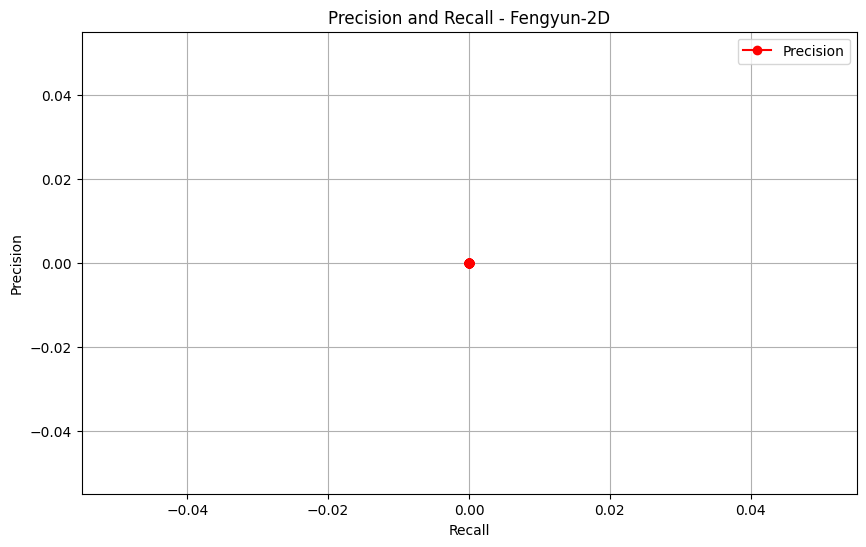

In [25]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(10,6))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - Fengyun-2D')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

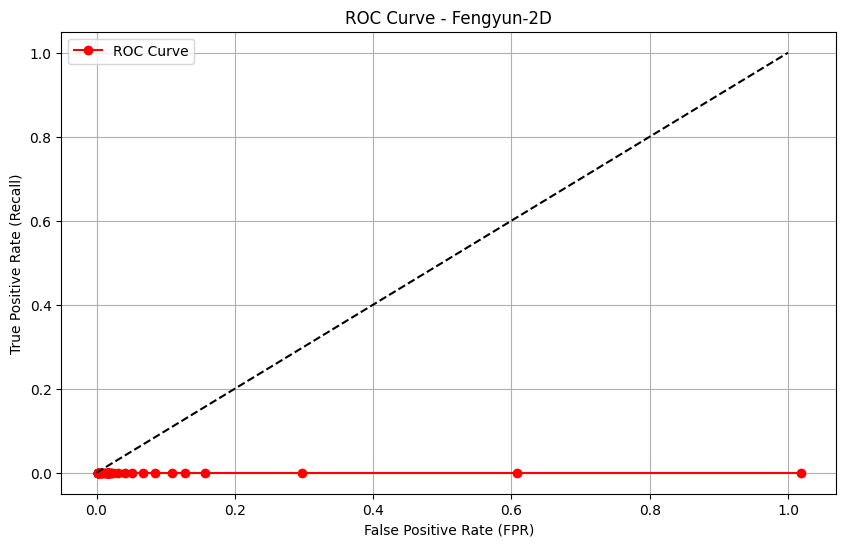

In [26]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(10,6))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - Fengyun-2D')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

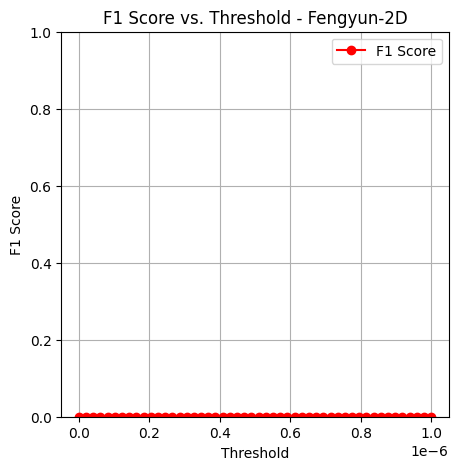

In [27]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - Fengyun-2D')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [28]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0
0.0


In [29]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

0.0
0.0
